# Hierarhical Modeling with MCMC

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_context('poster')

%matplotlib inline

import pymc3 as pm

import scipy

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Exploration

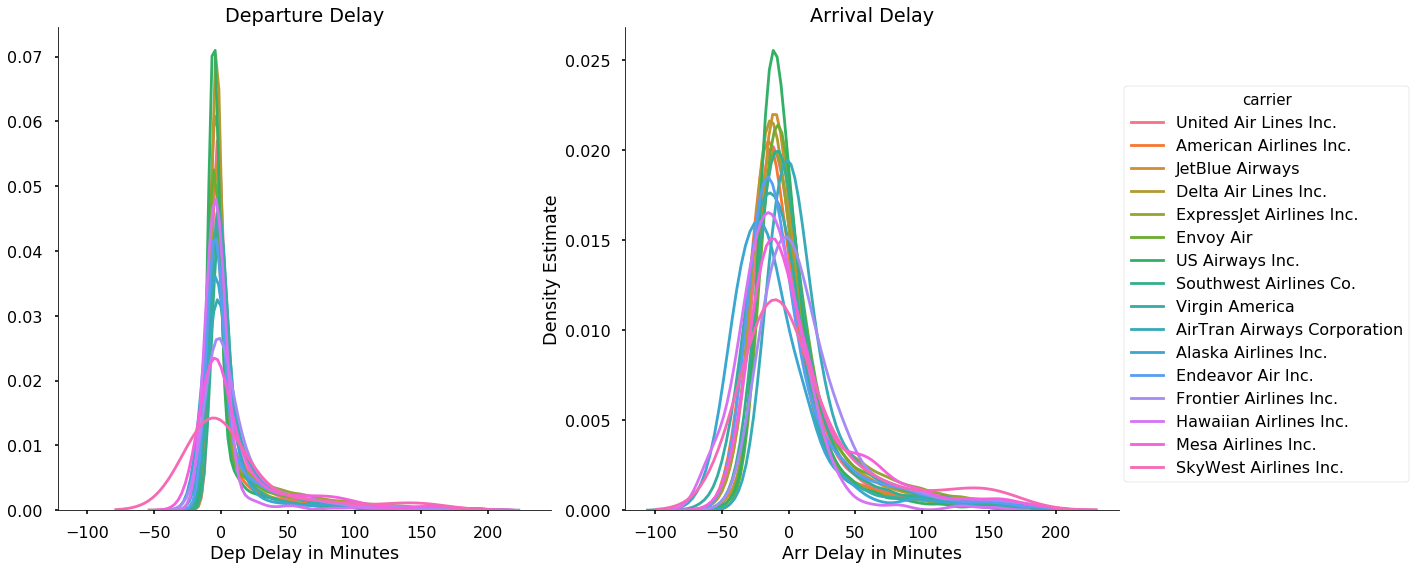

In [2]:
flights = pd.read_csv('data/flights.csv', index_col=0)
flights.dropna(subset=['dep_delay', 'arr_delay'], inplace=True)


carriers = pd.read_csv('data/airlines.csv')
flights = flights.merge(carriers, how = 'left', on = 'carrier' )
flights['carrier'] = flights['name']
flights.drop(columns='name', inplace=True)

flights = flights[(flights.dep_delay < 200) & (flights.arr_delay < 200)]
flights_subset = flights[['carrier', 'dep_delay', 'arr_delay']]
flights_melted = flights_subset.melt(id_vars='carrier', value_name='value', var_name='type')

figsize(16, 8)
grid = sns.FacetGrid(flights_melted, col = 'type', hue = 'carrier', size=8, sharey=False)
grid.map(sns.kdeplot, 'value')
grid.add_legend();
ax1 = grid.axes[0][0]
ax1.set_xlabel('Dep Delay in Minutes')
ax1.set_title('Departure Delay')

ax2 = grid.axes[0][1]
ax2.set_xlabel('Arr Delay in Minutes')
ax2.set_title('Arrival Delay');
plt.ylabel('Density Estimate');

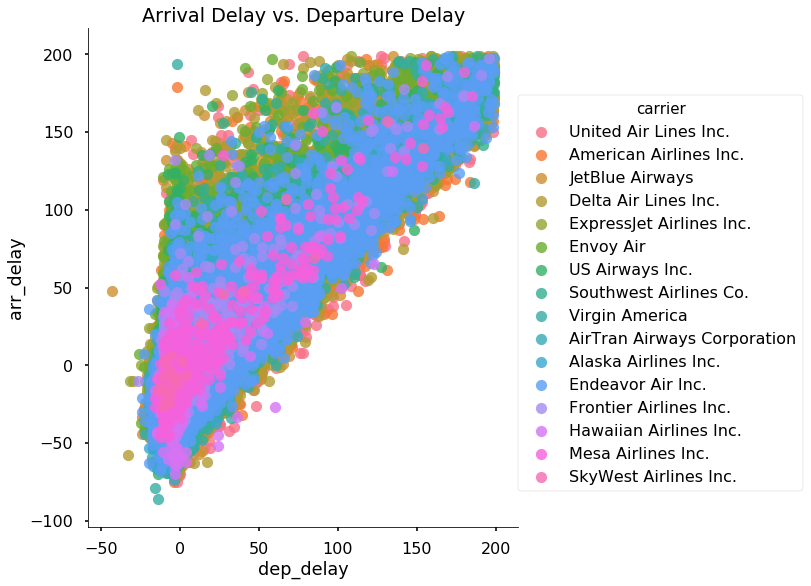

In [3]:
sns.lmplot('dep_delay', 'arr_delay', flights, 
           fit_reg = False, hue = 'carrier', size = 8);
plt.title('Arrival Delay vs. Departure Delay');

In [4]:
flights = flights.sample(frac=1, random_state=50)[:10000]

In [5]:
carriers = flights['carrier'].unique()
carrier_lookup = dict(zip(carriers, range(len(carriers))))
carrier_codes = flights['carrier_code'] = flights['carrier'].replace(carrier_lookup).values

# Hierarchical Model for Flight Delay

In [6]:
dep = np.array(flights['dep_delay'].values)
arr = np.array(flights['arr_delay'].values)

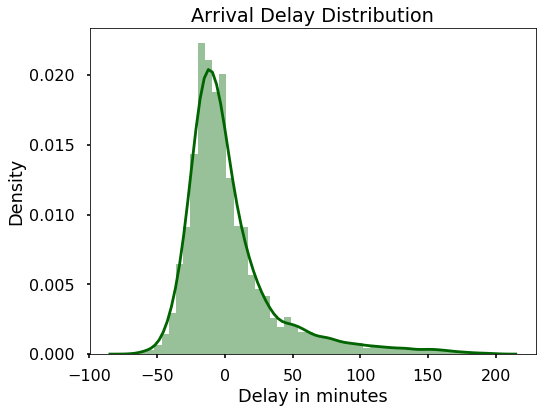

In [12]:
plt.figure(figsize=(8, 6))
sns.distplot(arr, color = 'darkgreen')
plt.title('Arrival Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

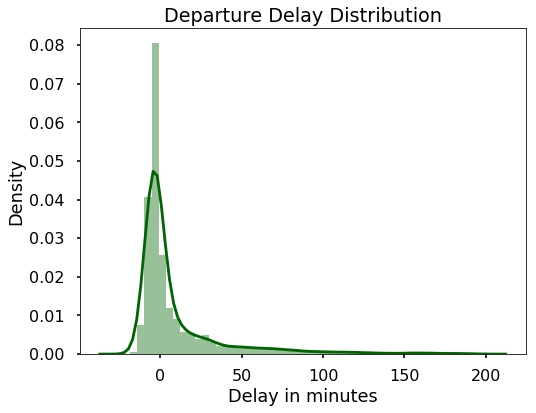

In [14]:
plt.figure(figsize=(8, 6))
sns.distplot(dep, color = 'darkgreen')
plt.title('Departure Delay Distribution');
plt.xlabel('Delay in minutes'); plt.ylabel('Density');

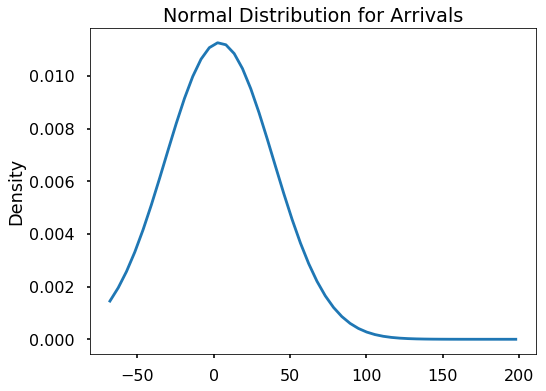

In [16]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(arr), max(arr))
skewed = scipy.stats.norm.pdf(x, loc = np.mean(arr),scale = np.std(arr))
plt.plot(x, skewed);
plt.title('Normal Distribution for Arrivals')
plt.ylabel('Density');

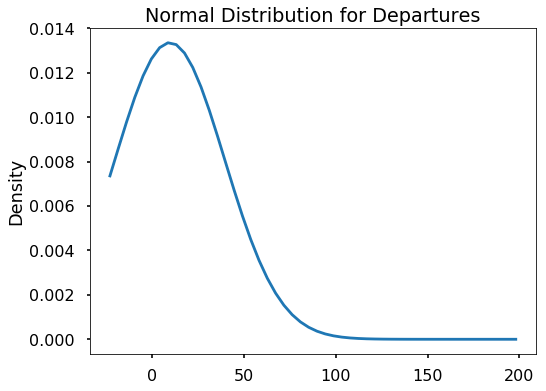

In [17]:
plt.figure(figsize=(8, 6))
x = np.linspace(min(dep), max(dep))
skewed = scipy.stats.norm.pdf(x, loc = np.mean(dep),scale = np.std(dep))
plt.plot(x, skewed);
plt.title('Normal Distribution for Departures')
plt.ylabel('Density');

In [18]:
print('Correlation between departure delay and arrival delay: {:.4f}.'.
      format(np.corrcoef(arr, dep)[0][1]))
print('Skew of Arrival Delay: {:.4f}.'.format(scipy.stats.skew(arr)))
print('Average Delay Time: {:.4f} minutes.'.format(np.mean(arr)))

Correlation between departure delay and arrival delay: 0.8631.
Skew of Arrival Delay: 2.0803.
Average Delay Time: 3.7169 minutes.


In [21]:
# Treat all of observations as coming from same distribution
with pm.Model() as pooled_model:
    
    # Beta is vector of model parameters: [intercept, slope]
    beta = pm.Normal('beta', testval = [0, np.corrcoef(arr, dep)[0][1]],
                     mu = 0, sd = 10, shape=2)
    
    # Sigma is standard deviation of observations
    sigma = pm.HalfCauchy('sigma', 5)
    
    # Linear equation for the arrival delay based on departure delay
    theta = beta[0] + beta[1] * dep
    
    # The arrival delays are skewed normal
    y = pm.Normal('y', mu=theta, sd=sigma, observed=arr)
    
    # Trace from pooled model
    pooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta]


In [23]:
# Intercept and slope are mean of traces
pooled_intercept, pooled_slope = pooled_trace['beta'].mean(axis=0)
pooled_sigma = pooled_trace['sigma'].mean(axis=0)

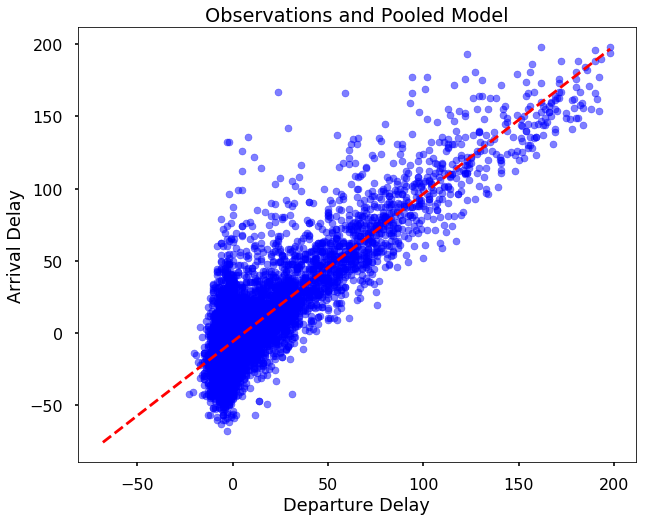

In [25]:
figsize(10, 8)
plt.scatter(flights['dep_delay'], (flights['arr_delay']), s = 50, 
           alpha = 0.5, facecolor = 'b', edgecolors = 'b')

xvals = np.linspace(min(arr), max(arr))

plt.plot(xvals, pooled_slope * xvals + pooled_intercept, 
         'r--', label = 'Pooled Model Estimate');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');
plt.title('Observations and Pooled Model');

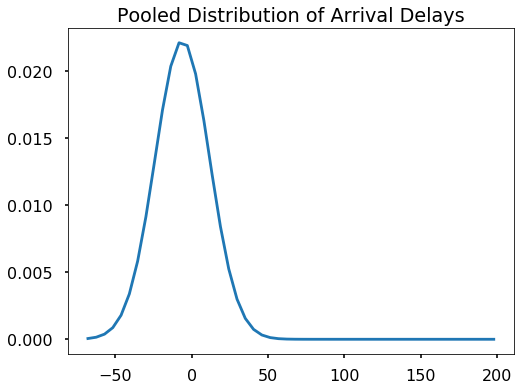

In [26]:
figsize(8, 6)
x = np.linspace(min(arr), max(arr))
pooled_dist = scipy.stats.norm.pdf(x, loc = pooled_intercept, 
                                      scale = pooled_sigma)
plt.plot(x, pooled_dist)
plt.title('Pooled Distribution of Arrival Delays');

# Completely Unpooled Model

In [28]:
carriers

array(['Delta Air Lines Inc.', 'American Airlines Inc.',
       'Endeavor Air Inc.', 'United Air Lines Inc.',
       'ExpressJet Airlines Inc.', 'US Airways Inc.', 'JetBlue Airways',
       'Southwest Airlines Co.', 'Virgin America',
       'AirTran Airways Corporation', 'Envoy Air',
       'Frontier Airlines Inc.', 'Alaska Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Mesa Airlines Inc.'], dtype=object)

In [31]:
with pm.Model() as unpooled_model:
    
    # Intercept
    beta0 = pm.Normal('beta0', 0, sd = 10, shape = len(carriers))
    
    # Slope
    beta1 = pm.Normal('beta1', 0, testval = np.corrcoef(arr, dep)[0][1], sd = 10)
    
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = beta0[carrier_codes] + beta1 * dep
    
    y = pm.Normal('y', theta, sd = sigma, observed = arr)
    unpooled_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, beta1, beta0]


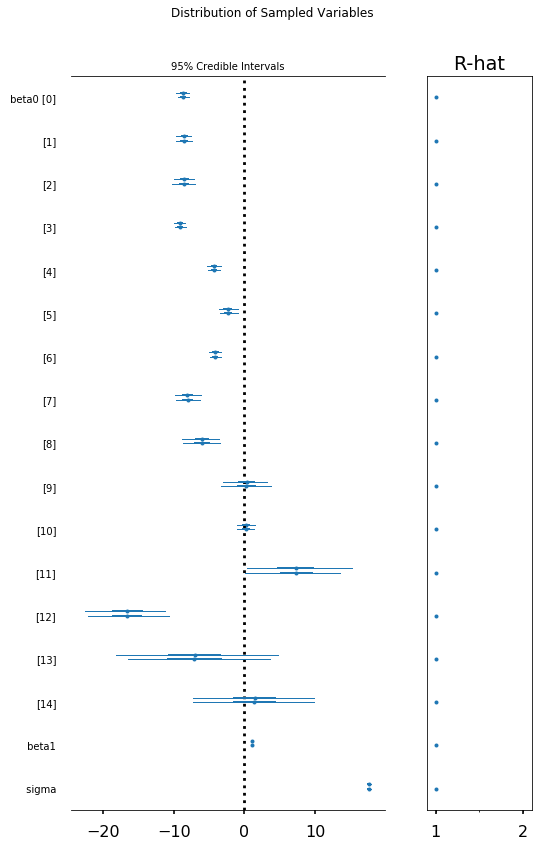

In [33]:
from pymc3 import forestplot

figsize(8, 12)
forestplot(unpooled_trace);
plt.suptitle('Distribution of Sampled Variables');

In [34]:
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = carriers)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = carriers)

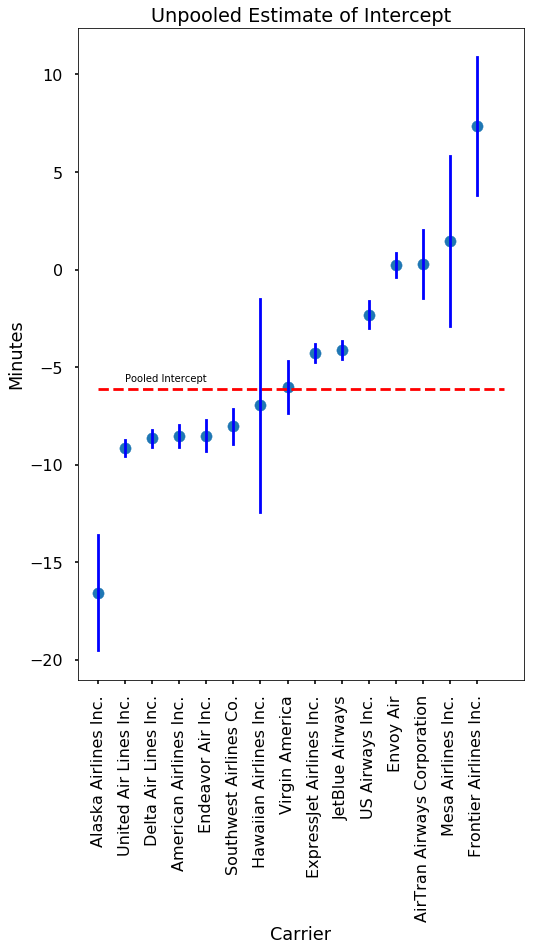

In [36]:
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i, i], [m - se, m + se], 'b-')
    
plt.xticks(range(len(unpooled_estimates)), order, rotation = 90);
plt.hlines( y = pooled_intercept, color = 'r', linestyles='--', xmin = 0, xmax = len(unpooled_estimates))
plt.text(x = 1, y = pooled_intercept + .4, s = 'Pooled Intercept')
plt.xlabel('Carrier'); plt.ylabel('Minutes');
plt.title('Unpooled Estimate of Intercept');

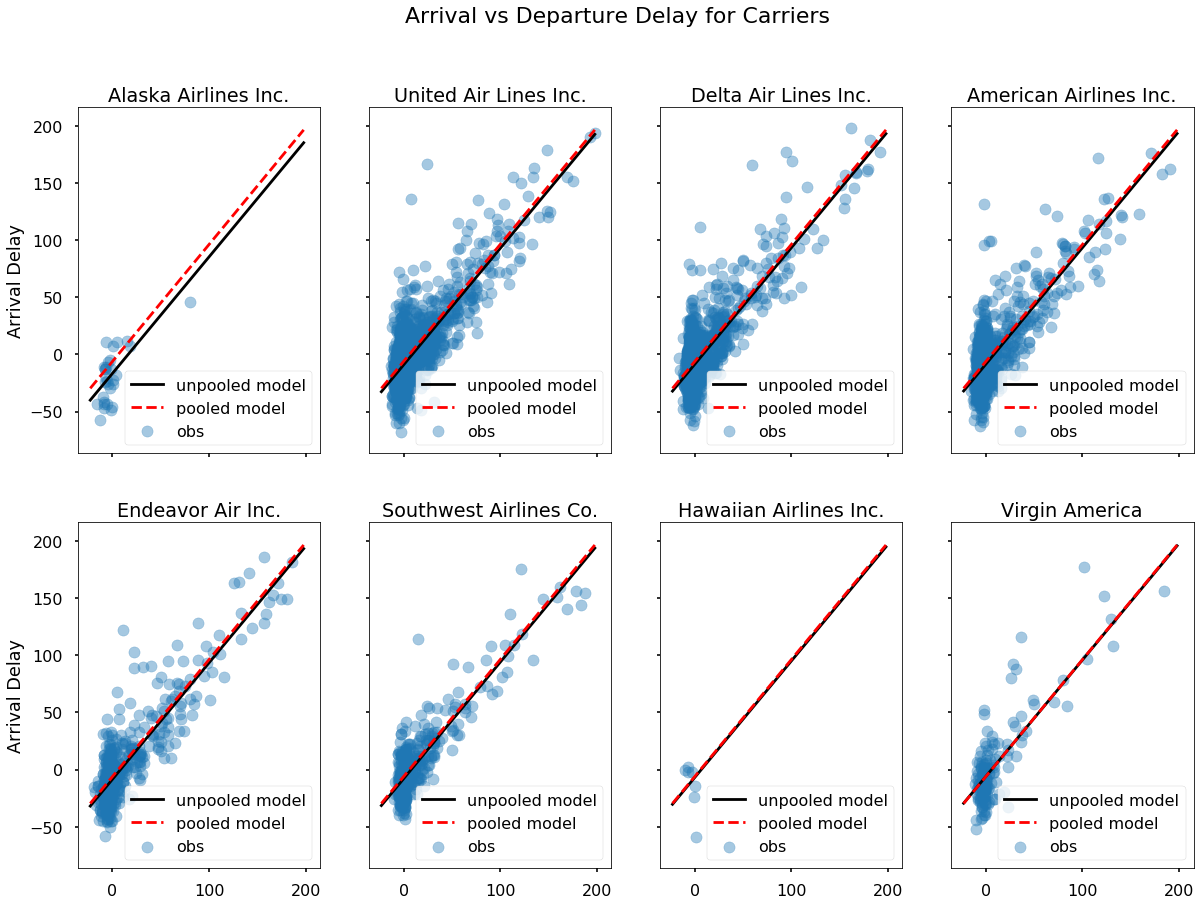

In [39]:
sample_airlines = tuple(order[:8])

fig, axes = plt.subplots(2, 4, figsize=(20, 14), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean()

for i,c in enumerate(sample_airlines):
    y = flights['arr_delay'][flights['carrier']==c]
    x = flights['dep_delay'][flights['carrier']==c]
    
    axes[i].scatter(x, y, alpha=0.4, label = 'obs')
    
    # No pooling model
    b = unpooled_estimates[c]
    # Plot both models and data
    xvals = np.linspace(min(dep), max(dep))
    axes[i].plot(xvals, m*xvals+b, label = 'unpooled model', color = 'k')
    axes[i].plot(xvals, pooled_slope*xvals+pooled_intercept, 'r--',
                label = 'pooled model')
    axes[i].set_title(c)
    axes[i].legend()
    if not i%4:
        axes[i].set_ylabel('Arrival Delay')
    
plt.suptitle('Arrival vs Departure Delay for Carriers', size = 22);

# Partial Pooling

## No predictors

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

In [40]:
with pm.Model() as partial_pooling:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta = 5)
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(carriers))

    # Expected Value
    y_hat = a[carrier_codes]
    
    # Model Error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    partial_pooling_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, a, sigma_a_log__, mu_a]
The acceptance probability does not match the target. It is 0.8807079251093625, but should be close to 0.8. Try to increase the number of tuning steps.


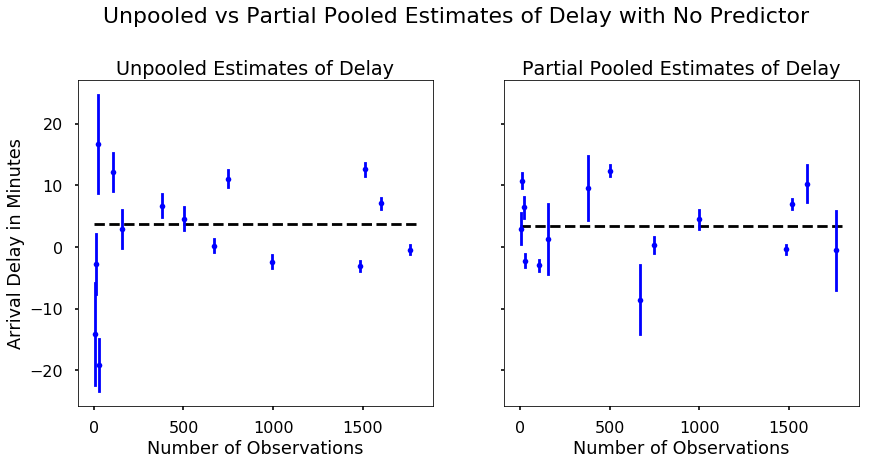

In [44]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

samples, n_carriers = sample_trace.shape

count_carriers = flights.groupby('carrier')['arr_delay'].count()
unpooled_means = flights.groupby('carrier')['arr_delay'].mean()
unpooled_sd = flights.groupby('carrier')['arr_delay'].std()

unpooled = pd.DataFrame({'n': count_carriers, 'm': unpooled_means, 'sd': unpooled_sd})
unpooled['se'] = unpooled['sd']/np.sqrt(unpooled.n)

axes[0].plot(unpooled['n'], unpooled['m'], 'b.')
axes[0].set_ylabel('Arrival Delay in Minutes')
axes[0].set_title('Unpooled Estimates of Delay')
axes[0].set_xlabel('Number of Observations')

for row in unpooled.iterrows():
    name, dat = row
    axes[0].plot([dat['n'], dat['n']], [dat['m'] - dat['se'], dat['m'] + dat['se']], 'b-')
    
axes[0].hlines(flights['arr_delay'].mean(), 0, 1800, linestyles='--')

means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].plot(count_carriers.values, means, 'b.')

for n, m, s in zip(count_carriers.values, means, sd):
    axes[1].plot([n]*2, [m-s, m+s], 'b-')
    
axes[1].set_title('Partial Pooled Estimates of Delay')
axes[1].hlines(sample_trace.mean(), 0, 1800, linestyles='--')
axes[1].set_xlabel('Number of Observations')
plt.suptitle("Unpooled vs Partial Pooled Estimates of Delay with No Predictor", y = 1.05, size = 22);

# Varying Intercept model

Allow the intercept to vary across carriers.

In [47]:
with pm.Model() as varying_intercept:
    
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.HalfCauchy('sigma_a', beta= 1)
    
    # Random intercepts for each carrier
    a = pm.Normal('a', mu = mu_a, sd = sigma_a, shape=len(carriers))
    
    # Common Slope
    b = pm.Normal('b', testval = np.corrcoef(arr, dep)[0][1], mu=0, sd=10)

    sd_y = pm.HalfCauchy('sd_y', beta= 5)
    
    y_hat = a[carrier_codes] + b * dep
    
    y_like = pm.SkewNormal('y_like', mu=y_hat, sd=sd_y, observed=arr)
    
    varying_intercept_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_y_log__, b, a, sigma_a_log__, mu_a]


In [ ]:
plt.figure(8, 18)
forestplot(varying_intercept_trace)
plt.suptitle('Estimates of Model Parameters for Varying Intercept Model', size=22)

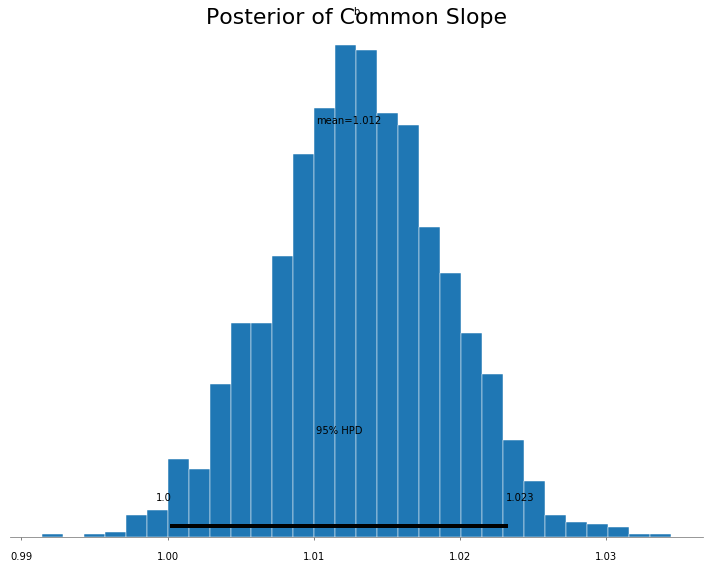

In [51]:
figsize(10, 8)
pm.plot_posterior(varying_intercept_trace, 
                 varnames = ['b']);
plt.suptitle('Posterior of Common Slope', size = 22);

In [52]:
pm.summary(varying_intercept_trace, varnames=['b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b,1.012365,0.005903,0.000097,1.000278,1.023147,2000.0,0.99981


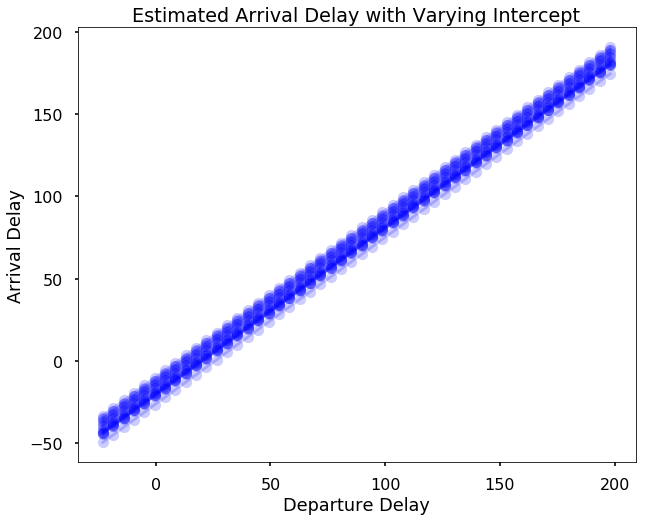

In [64]:
xvals = np.linspace(min(dep), max(dep))
bp = varying_intercept_trace[a].mean(axis=0)
se = varying_intercept_trace[a].std(axis=0) 
mp = varying_intercept_trace[b].mean()

for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha = 0.2)

plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay')
plt.title('Estimated Arrival Delay with Varying Intercept');

In [63]:
count_carriers.sort_values()

carrier
Hawaiian Airlines Inc.            7
Mesa Airlines Inc.               14
Frontier Airlines Inc.           23
Alaska Airlines Inc.             30
AirTran Airways Corporation     107
Virgin America                  159
Southwest Airlines Co.          382
Endeavor Air Inc.               504
US Airways Inc.                 668
Envoy Air                       749
American Airlines Inc.          996
Delta Air Lines Inc.           1483
ExpressJet Airlines Inc.       1515
JetBlue Airways                1601
United Air Lines Inc.          1762
Name: arr_delay, dtype: int64

In [54]:
bp

array([-20.33863778, -20.37175183, -20.30065677, -20.86935031,
       -15.62966027, -13.79043896, -15.83643032, -19.47419508,
       -18.19277084, -11.65518737, -11.35549974,  -9.7332503 ,
       -26.01362694, -18.92840929, -13.32981029])

In [55]:
carrier_lookup

{'AirTran Airways Corporation': 9,
 'Alaska Airlines Inc.': 12,
 'American Airlines Inc.': 1,
 'Delta Air Lines Inc.': 0,
 'Endeavor Air Inc.': 2,
 'Envoy Air': 10,
 'ExpressJet Airlines Inc.': 4,
 'Frontier Airlines Inc.': 11,
 'Hawaiian Airlines Inc.': 13,
 'JetBlue Airways': 6,
 'Mesa Airlines Inc.': 14,
 'Southwest Airlines Co.': 7,
 'US Airways Inc.': 5,
 'United Air Lines Inc.': 3,
 'Virgin America': 8}

# Varying Slope Model

In [72]:
with pm.Model() as varying_slope:
    
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.HalfCauchy('sigma_b', beta=5)
    
    a = pm.Normal('a', mu = 0, sd = 10)
    
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=len(carriers))
    
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    y_hat = a + b[carrier_codes] * dep
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    varying_slope_trace = pm.sample(1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]


In [73]:
varying_slope_trace[b].mean(axis=0)

array([1.0192133 , 0.97691402, 1.00056479, 0.97369672, 1.03730608,
       1.03711567, 1.04653399, 0.98837365, 1.05984259, 1.04011968,
       1.07648121, 1.02656877, 1.01837257, 1.01959626, 1.01660721])

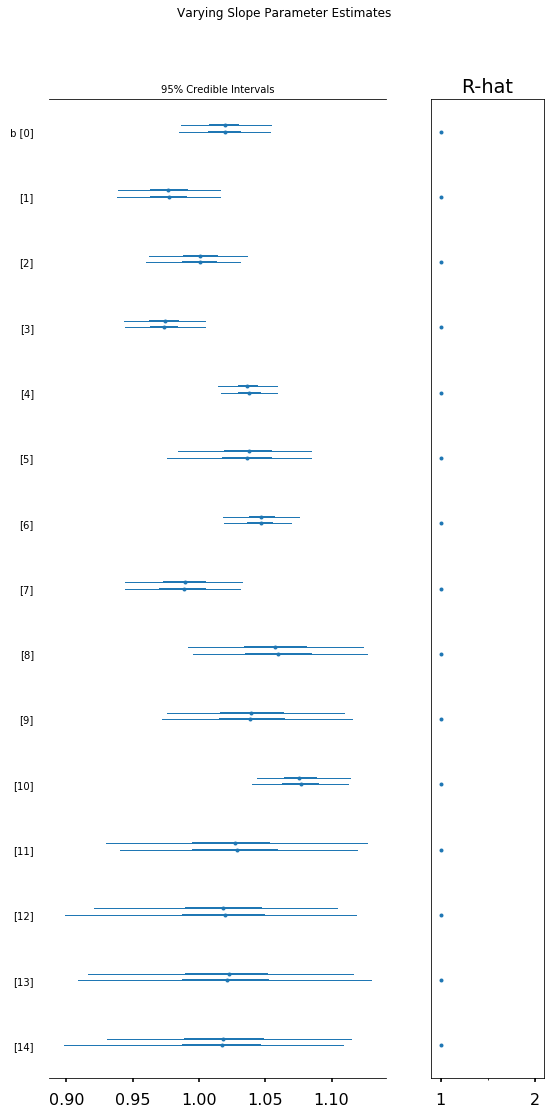

In [78]:
figsize(8, 16)
pm.forestplot(varying_slope_trace, varnames = ['b'])
plt.suptitle('Varying Slope Parameter Estimates');

# Varying Intercept and Slope Model

In [76]:
with pm.Model() as varying_intercept_slope:
    mu_a = pm.Normal('mu_a', mu=0, sd=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', beta=5)
    mu_b = pm.Normal('mu_b', mu=0, sd=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', beta=5)
    
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=len(carriers))
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=len(carriers))
    
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    y_hat = a[carrier_codes] + b[carrier_codes] * dep
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=arr)
    
    varying_intercept_slope_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 404 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.523761102180626e-06, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


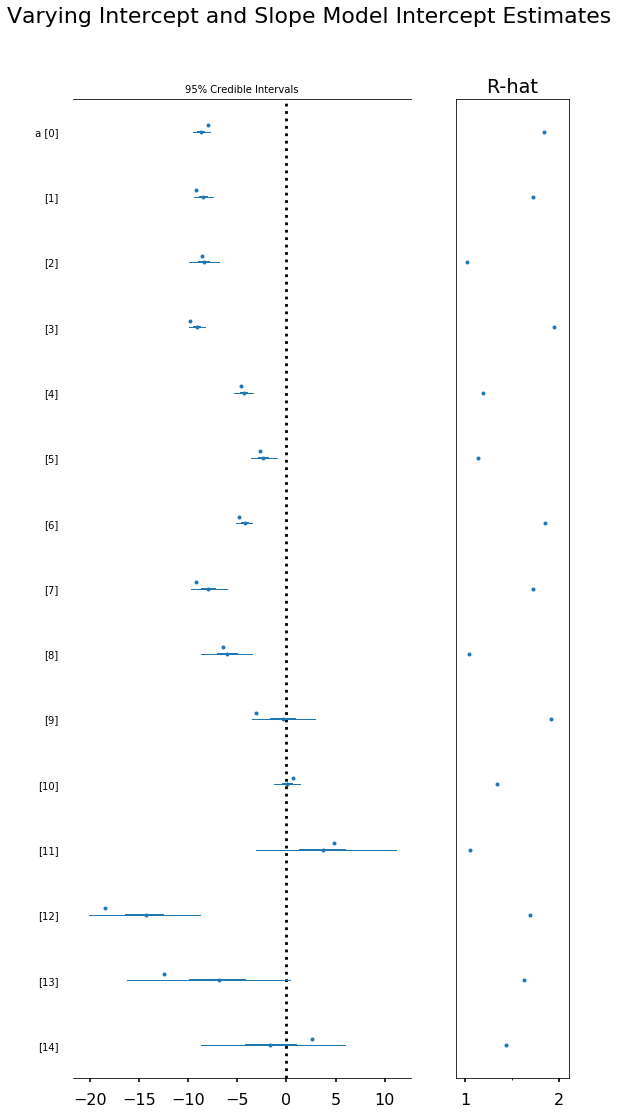

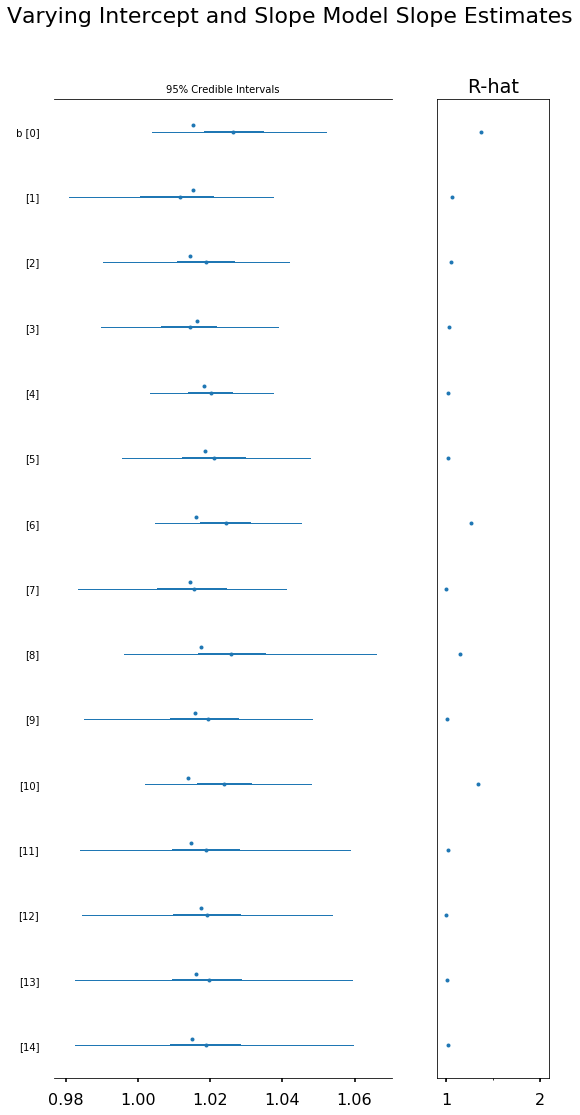

In [81]:
pm.forestplot(varying_intercept_slope_trace, varnames=['a']);
plt.suptitle('Varying Intercept and Slope Model Intercept Estimates', size=22);
plt.show();

pm.forestplot(varying_intercept_slope_trace, varnames=['b']);
plt.suptitle('Varying Intercept and Slope Model Slope Estimates', size=22);
plt.show();

Text(0,0.5,'Arrival Delay')

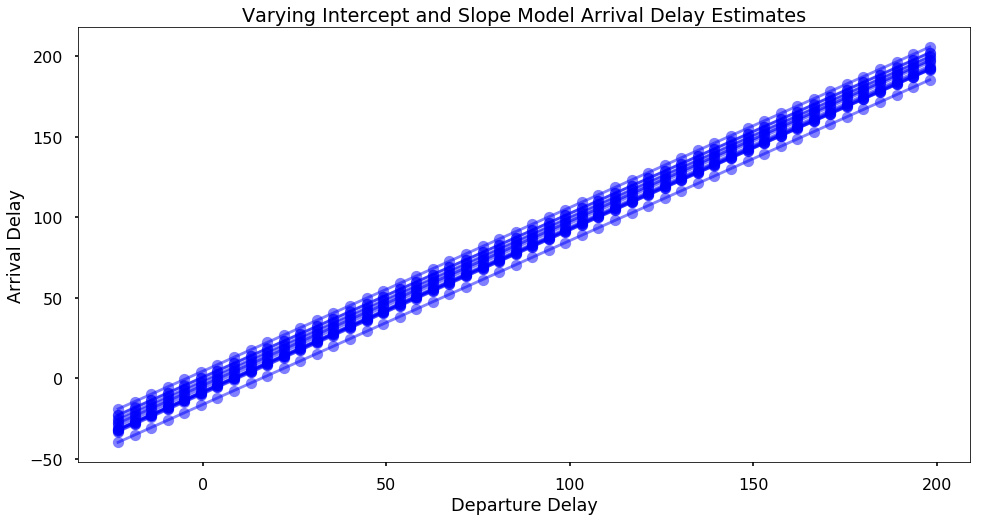

In [84]:
xvals = np.linspace(min(dep), max(dep))

b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)

figsize(16, 8)
for bi, mi in zip(b, m):
    plt.plot(xvals, mi*xvals+bi, 'bo-', alpha=0.5)
plt.title('Varying Intercept and Slope Model Arrival Delay Estimates');
plt.xlabel('Departure Delay'); plt.ylabel('Arrival Delay');